# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** This notebook takes care of downloading the data from either the weblink or the heroku database. Fixes all the errors in the data and outputs it to a ```.csv``` file

## Table of contents <a name="table-of-contents"></a>

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)  
3. [Wrangle the Data](#Wrangle-the-Data)<br>
    a. [restructure the dataframe](#restructure-the-dataframe)<br>
    b. [create a timeseries dataframe](#create-a-timeseries-dataframe)
4. [Fixing the errors in the data](#fixing)
5. [Exporting the data](#exporting)

## 1. Import Libraries <a name="Import-Libraries"></a>

To start, we will import some package: in this case, we will make use of:
* ```subprocess``` to run commands on our machine
* ```pandas```     to create dataframes and retreive data
* ```matplotlib``` to plot our data
* ```sqlalchemy``` to create an engine to connect to the database

In [1]:
import subprocess

import pandas            as pd
import ipywidgets        as widgets
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

plt.style.use('fivethirtyeight')

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

This cell is responsible for creating a nice interactive way to edit our settings. This is done by using the ```ipywidgets``` module and its ```.interactive()``` method.

**!!! RUN THIS CELL BEFORE CONTINUEING !!!**

In [2]:
def source_func(source):
    bryan_domain   = 'pxl-ss'
    jeffrey_domain = 'ss-pxl-11603121'
    
    if (source):
        return jeffrey_domain
    else:
        return bryan_domain
    
    return None

def method_func(method):
    
    if (method):
        return False
    else:
        return True
    
    return None

get_source = widgets.interactive(source_func, source=[('Bryan\'s database', 0), ('Jeffrey\'s database', 1)]);
get_method = widgets.interactive(method_func, method=[('Heroku Web Route', 0), ('Heroku Database', 1)]);

display(get_source)
display(get_method)

interactive(children=(Dropdown(description='source', options=(("Bryan's database", 0), ("Jeffrey's database", …

interactive(children=(Dropdown(description='method', options=(('Heroku Web Route', 0), ('Heroku Database', 1))…

In the above cell we declared the way we want to download our data. In the below cell we will accually download all the data.

This is done by either using the ```pandas``` module and its ```.read_json()``` method or by using a combination of the ```sqlalchemy``` and ```subprocess``` modules get the local heroku variables and connect/download the data directly form the database.

In [3]:
name_dbApp = get_source.result
method     = get_method.result

if (True == method):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url  = 'https://' + name_dbApp + '.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = name_dbApp
    TABLE_NAME      = "Temperature"
    
    # `subprocess.run()` will run the provided command on the localhost and store the returned value in `conn_info`
    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri   = conn_info.stdout.decode('utf-8').strip()

    # With the provided connection info we accually connect to the database
    engine     = create_engine(connuri)
    raw_engine = engine.raw_connection()

    # Execute the querry and store its results
    data = pd.read_sql_query("SELECT creation_date, value FROM Temperature;", raw_engine)

In [4]:
# Make sure we recieved the data correctly by printing out the last 4 values
data.tail(5)

,creation_date,id,place,value
1359,2018-11-25T12:33:23.056991+00:00,1392,"Lat:51.037460, Long: 5.301590",18.26
1360,2018-11-25T12:48:27.597162+00:00,1393,"Lat:51.037460, Long: 5.301590",18.06
1361,2018-11-25T13:03:33.110293+00:00,1394,"Lat:51.037460, Long: 5.301590",18.04
1362,2018-11-25T13:18:36.640218+00:00,1395,"Lat:51.037460, Long: 5.301590",17.94
1363,2018-11-25T13:33:40.220206+00:00,1396,"Lat:51.037460, Long: 5.301590",16.79


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

The first thing we want to do is get rid of the columns we are not interested in.

In this case we are only interested in the ```creation_date``` column and the ```value``` column. We will also rename these columns to ```dateTime``` and ```temperature``` just for ease of use. (A small optimization that could be applied is to directly edit the query to only get the ```creation_date``` and ```value``` columns. This would decrese the amount of data we are sending of the network.)

### a. restructure the dataframe <a name="restructure-the-dataframe">

In [5]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Double check the results of the reassignment
df.head(5)

,dateTime,temperature
0,2018-11-10T23:38:44.453789+00:00,21.48
1,2018-11-10T23:53:53.134313+00:00,19.48
2,2018-11-10T23:53:57.457321+00:00,20.60
3,2018-11-10T23:56:10.690055+00:00,20.45
4,2018-11-10T23:58:49.577553+00:00,20.76


### b. create a timeseries dataframe <a name="create-a-timeseries-dataframe">
    
Since we want a time series dataframe we still have to set the ```dateTime``` column to be our index. But to do this it still has to be converted to type type of ```Datetime``` first.

In [6]:
# Convert the creation_date column to datetime64
df['dateTime'] = pd.to_datetime(df.dateTime)
# Convert the value column to float
df['temperature'] = pd.to_numeric(df.temperature)

# Set the dateTime column as index
df.set_index(['dateTime'], inplace=True)

# Double check the results
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1364 entries, 2018-11-10 23:38:44.453789 to 2018-11-25 13:33:40.220206
Data columns (total 1 columns):
temperature    1364 non-null float64
dtypes: float64(1)
memory usage: 21.3 KB


In [7]:
df.tail(5)

,temperature
dateTime,
2018-11-25 12:33:23.056991,18.26
2018-11-25 12:48:27.597162,18.06
2018-11-25 13:03:33.110293,18.04
2018-11-25 13:18:36.640218,17.94
2018-11-25 13:33:40.220206,16.79


As can be seen in the cell above the dataFrame is successfully converted to an time series!

## 4. Fixing the errors in the data <a name="fixing"></a>

Like we will see next steps something went wrong when we were collecting our data.<br>
To fix this we are going to do 2 things.

* downsample our data to have a frequency of 15mins
* get rid of all NaN values

To make it easier to work with the data the index will be modified slightly. Since the original goal was to collect data every 15 minutes but some error happend while writing the firmware for the CC3200 (the few seconds it takes to connect to the AP, upload the data and disconnect was nog taken into acccount).

To kind of fix these errors, the dataframe is resampled. This means new "bins" for every 1 hour are made. Than the excisting data is looked at and if the data falls into once of these bins it is put into that bin. At the end when all the data has been put in its correspondending bin the mean is taken of every bin.

This can be easely done with the ```pandas``` ```.resample().mean()``` method.

In [8]:
# Change the frequency to 1 hour
df_resample = round(df.resample('H').mean(), 2)

In [9]:
df_resample.tail(5)

,temperature
dateTime,
2018-11-25 09:00:00,18.32
2018-11-25 10:00:00,17.99
2018-11-25 11:00:00,17.66
2018-11-25 12:00:00,18.62
2018-11-25 13:00:00,17.59


Looking at the output of ```df_resample.head(5)``` it can be observed that ```dateTime``` column now has a nice freqency of 15 minutes.

Next lets take a look if there is missing data.

In [10]:
df_resample.isnull().sum()

temperature    17
dtype: int64

The output of the ```.isnull().sum()``` tells us that there are NaN values. This can be the cause of many variables. Losing connection to the AP, the AP blew up, development board went up in flames, house went up in flames because the development board went up in flames, etc.

If we would plot out the current resampled data, the missing data can be clearly seen.

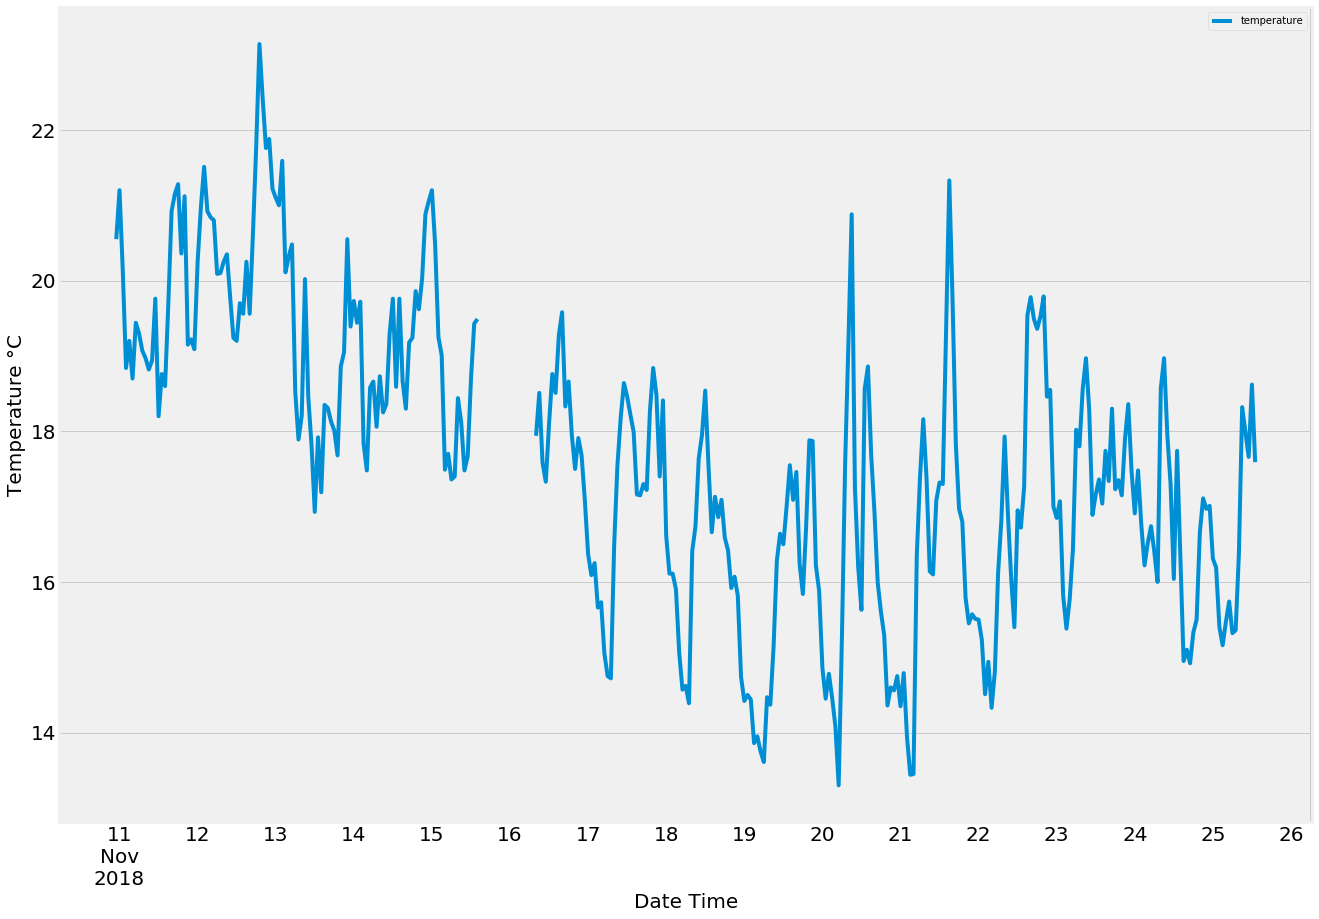

In [11]:
df_resample.plot(figsize=(20, 15), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

Fixing this is pretty easy, by using the ```pandas``` ```.interpolate()``` method it is easy to fill the missing data by connecting the end and beginning of the existing data.

In [12]:
df_resample = df_resample.interpolate(method='linear')
df_resample = df_resample.round(24)

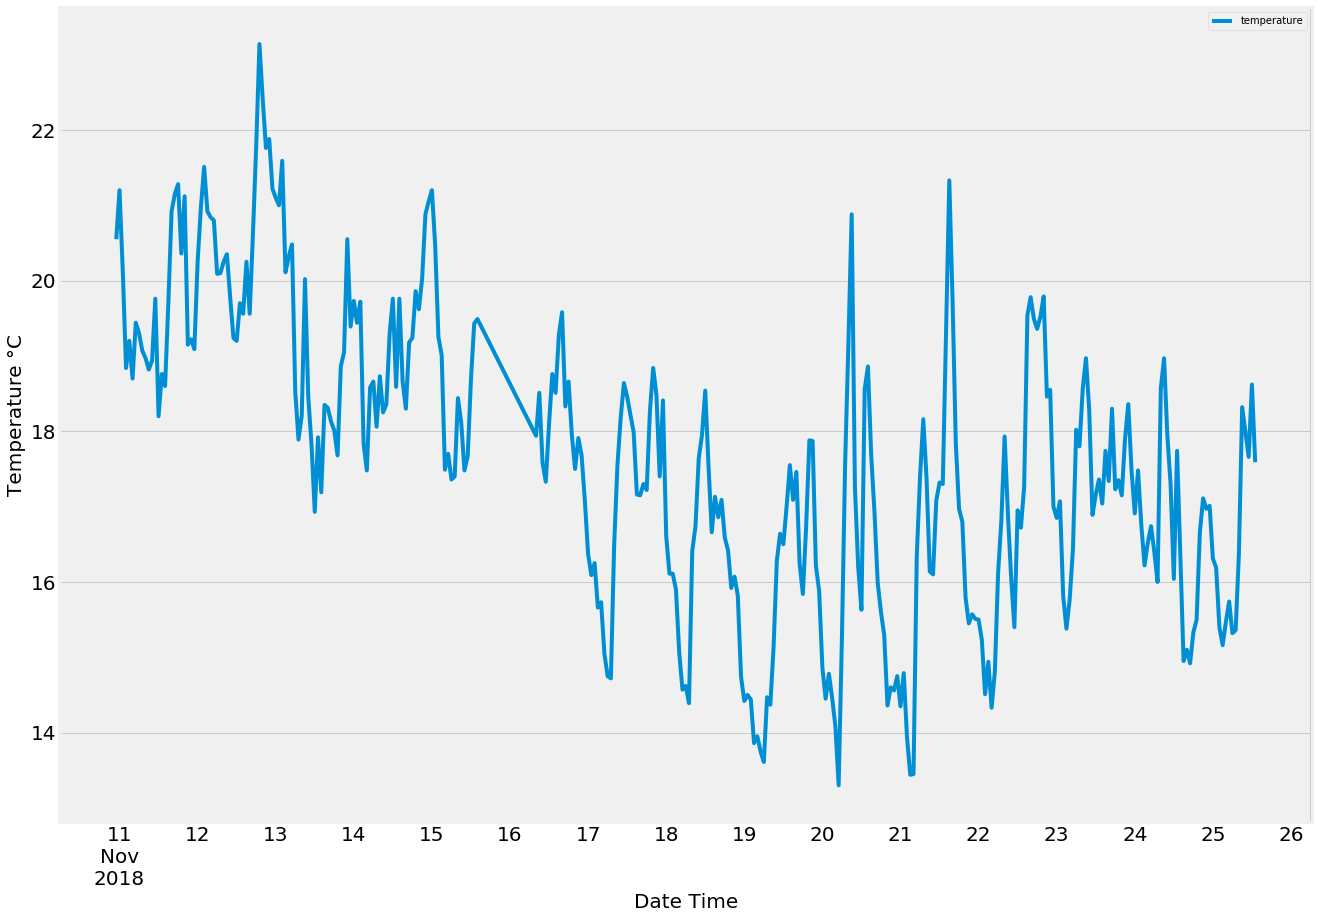

In [13]:
df_resample.plot(figsize=(20, 15), fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

As can be observed above the missing data has now been filled with "fake" data. Just as if the house fire never happend!

## 5. Exporting the data<a name="exporting"></a>

Now that we have the data in format we want it to be we are ready to export it. This can be done with the ```pandas``` ```.to_csv()``` method.

In [14]:
df = df_resample

In [15]:
df.to_csv('./data/data.csv')

**[⬆ back to top](#table-of-contents)** <br>
[next notebook](./3_exploratory_data_analysis.ipynb)